### Load/generate bits

This loads all numbers from the file and converts them a long string of 0s and 1s.

It also generates the same number of bits using the python built-in `secrets` library, which is cryptographically secure. We can use that to benchmark.

In [1]:
import secrets

files = [
    open("random_numbers2a.txt", "r"),
    open("random_numbers2b.txt", "r"),
    open("random_numbers2c.txt", "r"),
    open("random_numbers2d.txt", "r"),
    open("random_numbers2e.txt", "r"),
    open("random_numbers2f.txt", "r"),
    open("random_numbers2g.txt", "r")
]

random_file_bits = []

for file in files:
    random_file_bits_original = []
    for line in file:
        number = int(line.strip())
        binary = "{0:031b}".format(int(line))
        for bit in binary:
            random_file_bits_original.append(int(bit))

    random_file_bits_modified = []

    for ii in range(0, len(random_file_bits_original), 2):
        if random_file_bits_original[ii] == 0 and random_file_bits_original[ii + 1] == 1:
            random_file_bits_modified.append(0)
        if random_file_bits_original[ii] == 1 and random_file_bits_original[ii + 1] == 0:
            random_file_bits_modified.append(1)

    random_file_bits.append(random_file_bits_modified)
    

num_bits = len(random_file_bits[0])

random_gen_bits = [secrets.randbits(1) for _ in range(num_bits)]

### Chi-Square test

We perform an n-bit Chi-Square test to test the distribution of our bits. If the generated bits are random, the distribution should be roughly 1/2^n for every n-bit value.

P-value greater than 0.05 indicates success.

1-bit Chi-square test for random_file_bits
Number of bits: 7438250
Number of patterns: 2
Size of patterns: 1 bit(s)
Pattern counts: [3720079, 3718171]
Expected number per pattern: 3719125
Power_divergenceResult(statistic=np.float64(0.4894247974994118), pvalue=np.float64(0.4841840013387275))

Number of bits: 7448090
Number of patterns: 2
Size of patterns: 1 bit(s)
Pattern counts: [3723875, 3724215]
Expected number per pattern: 3724045
Power_divergenceResult(statistic=np.float64(0.015520757670758544), pvalue=np.float64(0.9008542157195445))

Number of bits: 7442079
Number of patterns: 2
Size of patterns: 1 bit(s)
Pattern counts: [3725034, 3717045]
Expected number per pattern: 3721039
Power_divergenceResult(statistic=np.float64(8.576114416415091), pvalue=np.float64(0.0034060142744217065))

Number of bits: 7446027
Number of patterns: 2
Size of patterns: 1 bit(s)
Pattern counts: [3723030, 3722997]
Expected number per pattern: 3723013
Power_divergenceResult(statistic=np.float64(0.000146252491

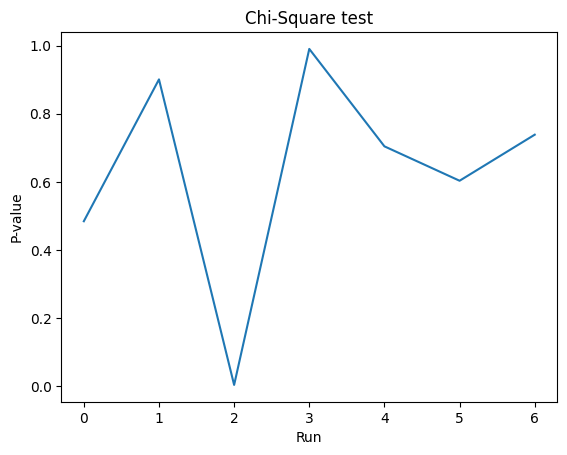


1-bit Chi-square test for random_gen_bits
Number of bits: 7438250
Number of patterns: 2
Size of patterns: 1 bit(s)
Pattern counts: [3718909, 3719341]
Expected number per pattern: 3719125
Power_divergenceResult(statistic=np.float64(0.025089772459920008), pvalue=np.float64(0.8741435725451896))


2-bit Chi-square test for random_file_bits
Number of bits: 7438250
Number of patterns: 4
Size of patterns: 2 bit(s)
Pattern counts: [921960, 939389, 936770, 921006]
Expected number per pattern: 1859562
Power_divergenceResult(statistic=np.float64(300.42383705844793), pvalue=np.float64(8.054496163115413e-65))



KeyboardInterrupt: 

In [9]:
from scipy.stats import chisquare
import matplotlib.pyplot as plt


def calculate_chisquare(bits, size):
    if len(bits) % size != 0:
        bits = bits[:len(bits) - len(bits) % size]

    split_bits = []
    for ii in range(0, len(bits), size):
        binary_sum = 0
        for jj in range(0, size):
            binary_sum += (bits[ii + jj]) * pow(2, size - jj - 1)
        split_bits.append(binary_sum)

    num_patterns = pow(2, size)
    expected_bits = int(len(bits) / num_patterns)
    pattern_counts = [len([x for x in split_bits if x == pattern]) for pattern in range(num_patterns)]

    print(f"Number of bits: {len(bits)}")
    print(f"Number of patterns: {num_patterns}")
    print(f"Size of patterns: {size} bit(s)")
    print(f"Pattern counts: {pattern_counts}")
    print(f"Expected number per pattern: {expected_bits}")

    return chisquare(f_obs=pattern_counts)


for i in [1, 2, 4]:
    print(f"{i}-bit Chi-square test for random_file_bits")
    values = []
    for random_bits in random_file_bits:
        v = calculate_chisquare(random_bits, i)
        print(v)
        print("")
        values.append(v.pvalue)

    plt.plot(values)
    plt.title("Chi-Square test")
    plt.xlabel("Run")
    plt.ylabel("P-value")
    plt.show()

    print("")

    print(f"{i}-bit Chi-square test for random_gen_bits")
    print(calculate_chisquare(random_gen_bits, i))
    print("\n")

### Auto-correlation test

To make sure there is no correlation between bits, we do this auto-correlation test.

The graph is supposed to show Y-value of 1 at lag (X) 0, and then Y-values close or equal to 0 at all other lag (X) values.

Lag is the offset for which values we compare, so a lag of 0 means we compare value at index 0 with value at index 0, which is obviously the same, so a correlation of 1. For all other lags the correlation should essentially be 0, so no correlation at all.

Autocorrelation for random_file_bits


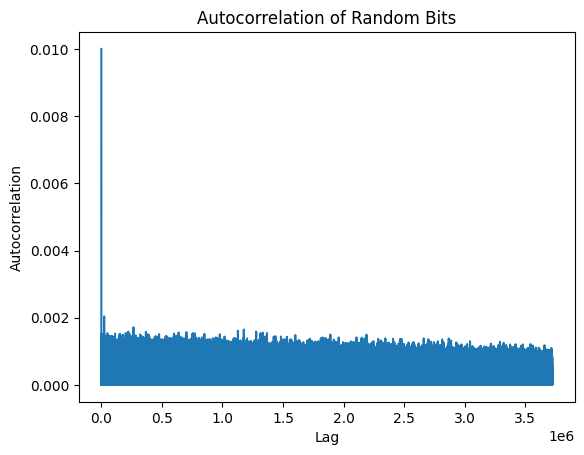


Autocorrelation for random_gen_bits


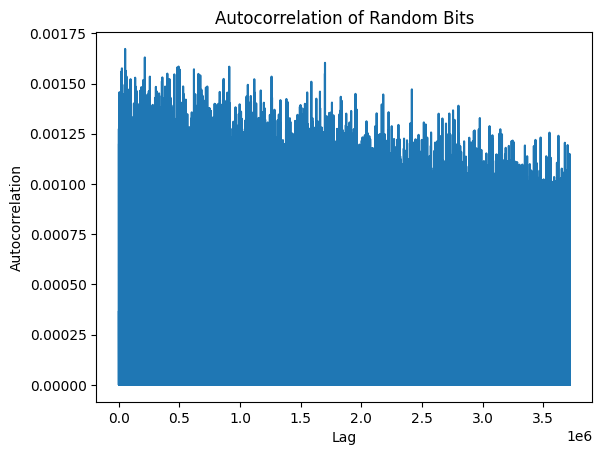


Autocorrelation for static sequence


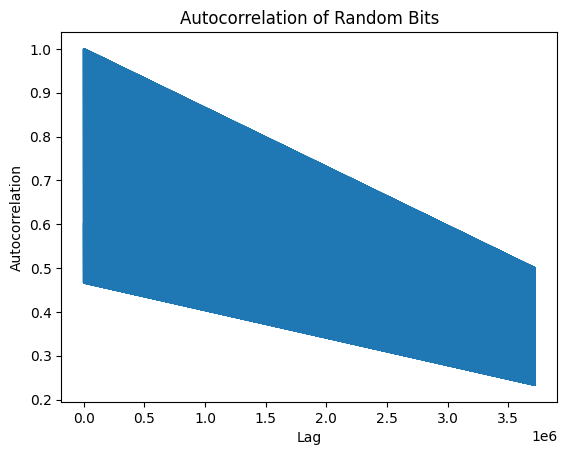

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate


def plot_autocorrelation(bits, size):
    if len(bits) % size != 0:
        bits = bits[:len(bits) - len(bits) % size]

    split_bits = []

    for ii in range(0, len(bits), size):
        binary_sum = 0
        for jj in range(0, size):
            binary_sum += (bits[ii + jj]) * pow(2, size - jj - 1)
        split_bits.append(binary_sum)

    autocorr = np.abs(correlate(split_bits - np.mean(split_bits), split_bits - np.mean(split_bits), "same"))
    autocorr = autocorr[(len(autocorr) // 2):]
    autocorr = autocorr.astype(np.float64)
    autocorr /= np.max(autocorr)

    plt.plot(autocorr[1:])  # Remove first entry, as it is always 1 and thus makes the graph kinda useless
    plt.title('Autocorrelation of Random Bits')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()


print("Autocorrelation for random_file_bits")
plot_autocorrelation(random_file_bits[3], 1)

print("\nAutocorrelation for random_gen_bits")
plot_autocorrelation(random_gen_bits, 1)

print("\nAutocorrelation for static sequence")
plot_autocorrelation([0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, ] * int(num_bits / 16), 1)

### Entropy

Very simple entropy calculation. Should be close to 1, which indicates 1 bit of randomness/information.

In [5]:
from scipy.stats import entropy


def calculate_entropy(bits):
    zeros = [x for x in bits if x == 0]
    ones = [x for x in bits if x == 1]

    p_0 = len(zeros) / num_bits
    p_1 = len(ones) / num_bits

    print(f"Entropy: {entropy([p_0, p_1], base=2)}")


print("Entropy for random_file_bits")
calculate_entropy(random_file_bits[0])
calculate_entropy(random_file_bits[1])
calculate_entropy(random_file_bits[2])
calculate_entropy(random_file_bits[3])
calculate_entropy(random_file_bits[4])
calculate_entropy(random_file_bits[5])
calculate_entropy(random_file_bits[6])

print("\nEntropy for random_gen_bits")
calculate_entropy(random_gen_bits)

Entropy for random_file_bits
Entropy: 0.9999999525365015
Entropy: 0.9999999984968145
Entropy: 0.999999168732278
Entropy: 0.9999999999858318
Entropy: 0.9999999860334796
Entropy: 0.9999999738286963
Entropy: 0.999999989194665

Entropy for random_gen_bits
Entropy: 0.9999999975668411


### Runs test

Tests the number of times we switch between a 0 and a 1, which tests for patterns. The z-score should be close to 0.

In [8]:
import math


def runs_test(bits):
    num_runs = 1
    num_ones = 1 if bits[0] == 0 else 0
    num_zeros = 1 if bits[0] == 1 else 0
    for ii in range(1, num_bits):
        if bits[ii] != bits[ii - 1]:
            num_runs += 1

        if bits[ii] == 0:
            num_zeros += 1
        else:
            num_ones += 1

    runs_exp = ((2 * num_zeros * num_ones) / (num_zeros + num_ones)) + 1
    stan_dev = math.sqrt(
        (2 * num_zeros * num_ones * (2 * num_zeros * num_ones - num_zeros - num_ones)) / (
                ((num_zeros + num_ones) ** 2) * (num_zeros + num_ones - 1)))

    z_score = (num_runs - runs_exp) / stan_dev

    print({
        "num_runs": num_runs,
        "runs_exp": runs_exp,
        "stan_dev": stan_dev,
        "z_score": z_score
    })


print("Runs test for random_file_bits")
runs_test(random_file_bits[0])

print("\nRuns test for random_gen_bits")
runs_test(random_gen_bits)

Runs test for random_file_bits
{'num_runs': 3751359, 'runs_exp': 3719125.7547743083, 'stan_dev': 1363.65758340365, 'z_score': 23.63734534093115}

Runs test for random_gen_bits
{'num_runs': 3720475, 'runs_exp': 3719125.987571001, 'stan_dev': 1363.6576687611037, 'z_score': 0.9892603253018319}
